In [2]:
#Loading Libraries
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Dropout, Concatenate, Input , Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from patchify import patchify, unpatchify

In [3]:
# Defining function to extract images from traget folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = img.resize((256,256))
            img = img.convert('RGB')
            img = np.array(img)
            images.append(img)
    
    images = np.array(images)
    images = images/255
    return images

In [4]:
#Location of image folder
noisy = r"C:/Users/prajw/OneDrive/Documents/DenoisingProject/All/low" 
clean = r"C:/Users/prajw/OneDrive/Documents/DenoisingProject/All/high" 

In [5]:
# x-->Low and noisy images
# y-->High and non-noisy target images
x = load_images_from_folder(noisy)
y = load_images_from_folder(clean)

In [6]:
# Creating more data images by making patches
# In this code each image is divided into 16 images
patch_size = 64

noisy_patches = np.vstack([patchify(img, (patch_size, patch_size, 3), step=patch_size) for img in x])
clean_patches = np.vstack([patchify(mask, (patch_size, patch_size, 3), step=patch_size) for mask in y])

noisy_patches = noisy_patches.reshape(-1, patch_size, patch_size, 3)
clean_patches = clean_patches.reshape(-1, patch_size, patch_size, 3)

In [7]:
# Building class for model building with required functions
class ChannelAttention(Layer):
    def __init__(self, filters, ratio=16):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.fc1 = layers.Conv2D(filters // ratio, 1, activation='relu', padding='same')
        self.fc2 = layers.Conv2D(filters, 1, padding='same')

    def call(self, x):
        avg_out = self.fc2(self.fc1(tf.expand_dims(tf.expand_dims(self.avg_pool(x), 1), 1)))
        max_out = self.fc2(self.fc1(tf.expand_dims(tf.expand_dims(self.max_pool(x), 1), 1)))
        return x * tf.sigmoid(avg_out + max_out)

class SpatialAttention(Layer):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = layers.Conv2D(1, kernel_size, activation='sigmoid', padding='same')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_out = tf.reduce_max(x, axis=-1, keepdims=True)
        return x * self.conv(tf.concat([avg_out, max_out], axis=-1))

def conv_block(x, filters, kernel_size, strides, activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def residual_block(x, filters):
    shortcut = x
    x = conv_block(x, filters, 3, 1, activation='relu')
    x = conv_block(x, filters, 3, 1, activation=None)
    x = ChannelAttention(filters)(x)
    x = SpatialAttention()(x)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [8]:
# Model Building
def model_creation(input_shape=(None, None, 3), num_residual_blocks=10):
    inputs = layers.Input(shape=input_shape)
    x = conv_block(inputs, 64, 3, 1, activation='relu')
    
    for _ in range(num_residual_blocks):
        x = residual_block(x, 64)
    
    x = conv_block(x, 64, 3, 1, activation='relu')
    x = layers.Conv2D(3, 3, strides=1, padding='same')(x)
    
    outputs = layers.Add()([x, inputs])
    model = models.Model(inputs, outputs)
    return model

In [9]:
# Defining model, optimizers and loss.
resnet_1 = model_creation()
resnet_1.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss=losses.MeanSquaredError())

In [10]:
# Variable learning rate and early stopping
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
]

In [12]:
# Training the data to the model
resnet_1.fit(noisy_patches,clean_patches, epochs=25, callbacks=callbacks,batch_size=16, validation_split=0.1)

Epoch 1/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 296s 677ms/step - loss: 0.0347 - val_loss: 0.0194 - learning_rate: 1.0000e-04
Epoch 2/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 305s 698ms/step - loss: 0.0203 - val_loss: 0.0199 - learning_rate: 1.0000e-04
Epoch 3/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 303s 694ms/step - loss: 0.0189 - val_loss: 0.0196 - learning_rate: 1.0000e-04
Epoch 4/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 310s 709ms/step - loss: 0.0185 - val_loss: 0.0178 - learning_rate: 1.0000e-04
Epoch 5/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 305s 697ms/step - loss: 0.0177 - val_loss: 0.0186 - learning_rate: 1.0000e-04
Epoch 6/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 308s 704ms/step - loss: 0.0179 - val_loss: 0.0186 - learning_rate: 1.0000e-04
Epoch 7/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 307s 702ms/step - loss: 0.0170 - val_loss: 0.0183 - learning_rate: 1.0000e-04
Epoch 8/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 314s 718ms/step - loss: 0.0169 - val_loss: 0.0167 - learning_rate: 1.0000e-04
Epoch 9/25
437/437 ━━━━━━━━━━━━━━━━━━━━ 311s 711ms/step 

In [13]:
# Prediction 
x_denoised = resnet_1.predict(x)

16/16 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step


In [14]:
# Define function for psnr
def psnr(target, ref):
    target_data = np.array(target, dtype=np.float32)
    ref_data = np.array(ref, dtype=np.float32)
    diff = ref_data - target_data
    rmse = np.sqrt(np.mean(diff ** 2))
    psnr_value = 20 * np.log10(1.0 / rmse)
    return psnr_value

In [15]:
# Calculate PSNR for x
psnr_values = [psnr(y[i], x[i]) for i in range(len(y))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

Average PSNR: 7.765406973920432


In [16]:
# Calculate PSNR for x_denoised
psnr_values = [psnr(y[i], x_denoised[i]) for i in range(len(y))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

Average PSNR: 21.966737012502627


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


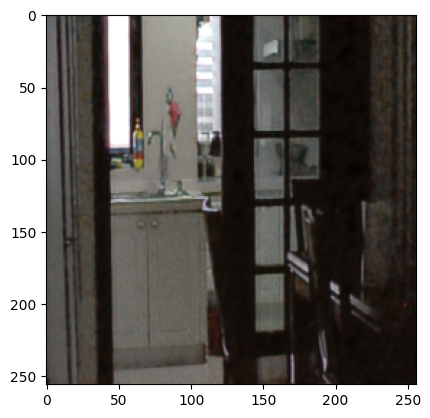

In [17]:
# Image obtained by first denoising model
plt.imshow(x_denoised[4])
plt.show()

In [18]:
# Creating more data images by making patches
# In this code each image is divided into 64 images
patch_size_2 = 32
x_denoised_patches = np.vstack([patchify(img, (patch_size_2, patch_size_2, 3), step=patch_size_2) for img in x_denoised])
x_denoised_patches = x_denoised_patches.reshape(-1, patch_size_2, patch_size_2, 3)
y_patches_2 = np.vstack([patchify(mask, (patch_size_2, patch_size_2, 3), step=patch_size_2) for mask in y])
y_patches_2 = y_patches_2.reshape(-1, patch_size_2, patch_size_2, 3)

In [19]:
# Passing the x_denoised again in the same moel with new features and optimizers
# Defining the new model
resnet_2 = model_creation()
resnet_2.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=losses.MeanSquaredError())

In [20]:
resnet_2.fit(x_denoised_patches,y_patches_2, epochs=35, callbacks=callbacks,batch_size=16, validation_split=0.1)

Epoch 1/35
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 310s 173ms/step - loss: 0.0103 - val_loss: 0.0133 - learning_rate: 1.0000e-04
Epoch 2/35
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 296s 170ms/step - loss: 0.0099 - val_loss: 0.0135 - learning_rate: 1.0000e-04
Epoch 3/35
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 295s 169ms/step - loss: 0.0097 - val_loss: 0.0132 - learning_rate: 1.0000e-04
Epoch 4/35
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 294s 168ms/step - loss: 0.0096 - val_loss: 0.0138 - learning_rate: 1.0000e-04
Epoch 5/35
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 297s 170ms/step - loss: 0.0098 - val_loss: 0.0137 - learning_rate: 1.0000e-04
Epoch 6/35
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 293s 168ms/step - loss: 0.0097 - val_loss: 0.0133 - learning_rate: 1.0000e-04
Epoch 7/35
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 376s 215ms/step - loss: 0.0096 - val_loss: 0.0136 - learning_rate: 1.0000e-04
Epoch 8/35
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 294s 168ms/step - loss: 0.0093 - val_loss: 0.0135 - learning_rate: 1.0000e-04
Epoch 9/35
1746/1746 ━━━━━━━━━━━━━━━━━━━

In [21]:
x_denoised_2 = resnet_2.predict(x_denoised)

16/16 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step


In [22]:
# Calculating psnr for final denoised image i.e. x_denoised_2
psnr_values = [psnr(y[i], x_denoised_2[i]) for i in range(len(y))]
average_psnr = np.mean(psnr_values)
print(f'Average PSNR: {average_psnr}')

Average PSNR: 22.40630827001062


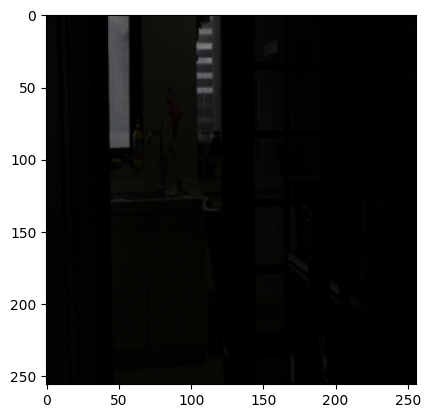

In [26]:
# Original images
plt.imshow(x[4])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


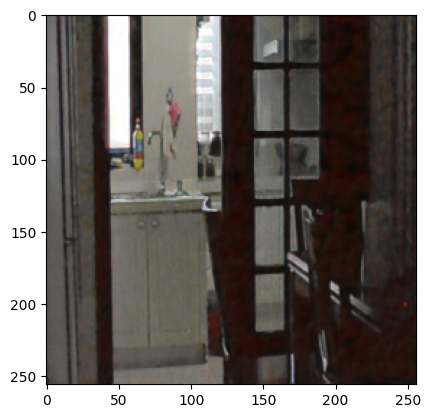

In [27]:
# Final denoised images
plt.imshow(x_denoised_2[4])
plt.show()

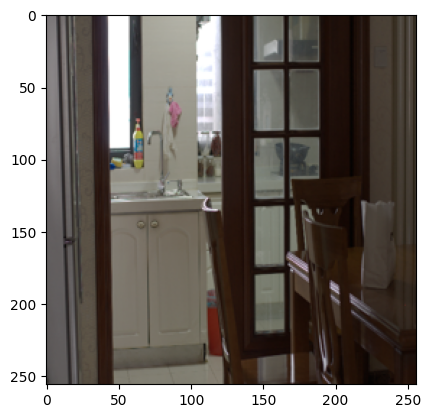

In [28]:
# Target images 
plt.imshow(y[4])
plt.show()

In [1]:
resnet_2.save('resnet_2.h5')
resnet_1.save('resnet_1.h5')
from keras.models import load_model
resnet_1 = load_model('resnet1.h5')
resnet_2 = load_model('resnet2.h5')

NameError: name 'resnet_2' is not defined

In [ ]:
import os
import numpy as np
from PIL import Image

def save_images_to_folder(images, folder):
    """
    Saves a list or array of images to a specified folder.

    Parameters:
    - images: List or array of images (numpy arrays).
    - folder: The directory where the images will be saved.
    """
    # Ensure the output directory exists
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    for i, img in enumerate(images):
        # Convert the image array to an Image object
        img = (img * 255).astype(np.uint8)  # Convert to uint8 type
        img_pil = Image.fromarray(img)
        
        # Define the output file path
        output_file_path = os.path.join(folder, f'image_{i}.png')
        
        # Save the image
        img_pil.save(output_file_path)




In [37]:
X_test = r"./test/low"
X_test = load_images_from_folder(X_test)
patch_size = 64
X_test_patches_1 = np.vstack([patchify(img, (patch_size, patch_size, 3), step=patch_size) for img in X_test])
X_test_denoised_1 = resnet_1.predict(X_test_patches_1)
patch_size = 32
X_test_patches_2 = np.vstack([patchify(img, (patch_size, patch_size, 3), step=patch_size) for img in X_test_denoised_1])
X_denoised_2 = resnet_2.predict(X_test_patches_2)
output_folder = r"./test/predicted"
save_images_to_folder(X_denoised_2, output_folder)


FileNotFoundError: [WinError 3] The system cannot find the path specified: './test/low'